# **Import ad install the Dependencies**

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!mkdir data/glove

!wget http://nlp.stanford.edu/data/glove.6B.zip

!unzip glove.6B.zip

In [285]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import tensorflow as tf
import matplotlib.pyplot as plt
import string
import keras.backend as K

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Dense,Conv1D,MaxPooling1D
from keras import models
from keras import layers
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

%matplotlib inline

# **Functions For cleaning Text**

In [286]:
def remove_links(tweet):
    '''Ex:- https://www.google.com.eg/'''
    return re.sub("(http[s]?:\S+)","", tweet)

def remove_shortwords(tweet):
    tweet=re.sub("'", "", tweet)
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if  len(word) > 1]
    return " ".join(clean_tweet)


def remove_mentions(tweet):
    '''@User Mention'''
    return re.sub("@[A-Za-z0-9_]+","", tweet)


def remove_stopwords(tweet):
    stopwords_list = stopwords.words('english')
    tweet = tweet.split()
    clean_tweet = [word for word in tweet if (word not in stopwords_list)]
    return " ".join(clean_tweet)

def remove_nonwords(tweet):
    tweet = re.sub('[^\w]',' ',tweet)
    return tweet

def clean_text(tweet):
    tweet = remove_links(tweet)
    tweet = remove_mentions(tweet)
    tweet = tweet.lower()
    tweet = remove_stopwords(tweet)
    tweet = remove_nonwords(tweet)
    tweet = remove_shortwords(tweet)
    tweet = tweet.strip()
    return tweet

# **Measurements (recall, precision, fscore)**

In [287]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# **Data Reading and Preprocessing**

In [288]:
num_of_words = 32000 
max_num_of_words = 50 # in sequence
num_of_dimensions = 300  # For GloVe word embeddings

### Data Reading and Cleaning

In [289]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/file.csv')
df.tweets = df.tweets.apply(clean_text)

### Show Majority of tweets

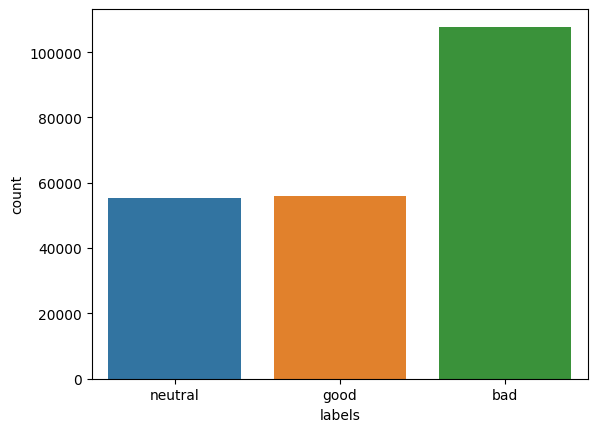

In [290]:
tweets_majority=sns.countplot(data=df, x='labels')
plt.show()
tweets_majority_fig = tweets_majority.get_figure()
tweets_majority_fig.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/Majority of tweets.png')

### Tokenization

In [291]:
tokenized_tweet = df['tweets'].apply(lambda x: word_tokenize(x))
tokenized_tweet.head()

0    [chatgpt, optimizing, language, models, dialogue]
1    [try, talking, chatgpt, new, ai, system, optim...
2    [chatgpt, optimizing, language, models, dialog...
3    [thrilled, share, chatgpt, new, model, optimiz...
4    [minutes, ago, released, new, chatgpt, nand, u...
Name: tweets, dtype: object

### Lemmatization

In [292]:
lemmatizer = WordNetLemmatizer()
tokenized_tweet = tokenized_tweet.apply(lambda sentence: [lemmatizer.lemmatize(word) for word in sentence])
tokenized_tweet.head()

for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])
    
df['tweets'] = tokenized_tweet
df.head()

,Unnamed: 0,tweets,labels
0,0,chatgpt optimizing language model dialogue,neutral
1,1,try talking chatgpt new ai system optimized di...,good
2,2,chatgpt optimizing language model dialogue ai ...,neutral
3,3,thrilled share chatgpt new model optimized dia...,good
4,4,minute ago released new chatgpt nand use right,bad


### Splittig the dataset to training and testing

In [293]:
X_train, X_test, y_train, y_test = train_test_split(df.tweets, df.labels, test_size=0.2, random_state=42)
print(f'# number of training data: {X_train.shape[0]}')
print(f'# number of testing data: {X_test.shape[0]}')

# number of training data: 175435
# number of testing data: 43859


### Generating Training and testing Data Files

In [ ]:
training_data=pd.DataFrame({'tweets':X_train[:], 'labels':y_train[:]})
testing_data=pd.DataFrame({'tweets':X_test[:], 'labels':y_test[:]})
training_data.to_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/training data/training_data.csv')
testing_data.to_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/testing data/testing_data.csv')

# **Text Processing**

In [294]:
tokenizer = Tokenizer(num_words=num_of_words,filters=string.punctuation)
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

In [295]:
data_description = X_train.apply(lambda x: len(x.split(' ')))
data_description_df=pd.DataFrame(data_description.describe())
data_description_df

,tweets
count,175435.000000
mean,12.629202
std,7.920655
min,1.000000
25%,6.000000
50%,10.000000
75%,18.000000
max,49.000000


In [296]:
max_num_of_words=49


X_train = pad_sequences(X_train_sequences, maxlen=max_num_of_words)
X_test = pad_sequences(X_test_sequences, maxlen=max_num_of_words)

print(f'Shape of samples: {X_train.shape}')

Shape of samples: (175435, 49)


### Format Output

In [ ]:
label_encoder = LabelEncoder()
y_train = to_categorical(label_encoder.fit_transform(y_train))
y_test = to_categorical(label_encoder.transform(y_test))
y_test[0]

# **Reading Glove Word Embeddings**

In [18]:
embedding_dict = {}
glove = open(f'/content/glove.6B.300d.txt', encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    embedding_dict[word] = vector
glove.close()

In [19]:
embedding_matrix = np.zeros((num_of_words, 300))

for w, i in tokenizer.word_index.items():
    if i < num_of_words:
        vect = embedding_dict.get(w)
        if vect is not None:
            embedding_matrix[i] = vect
    else:
        break

print ('Embedding Matrix Shape: ',embedding_matrix.shape)

Embedding Matrix Shape:  (32000, 300)


# **Models Training**

## **Fucntion for Plotting The Accuracy and Loss**


In [ ]:
def plotting_model_measurements(history,model_name,trial_num):
    title_name=f'{model_name} Model (Trial-{trial_num})'
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    fig.subplots_adjust(hspace=0.8, wspace=0.8)
    fig.suptitle(title_name, fontsize=16)
    fig.trial_num=trial_num
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    plt.savefig(f'/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/{model_name} Model Accuracy and Loss (Trial No.:{trial_num}).png')
    plt.draw()
    plt.tight_layout()

# **Using Convolutional Neural Network(CNN) Architecture**


## **Building The Model**

In [51]:


def build_CNN(Conv1D_1,Conv1D_2,Conv1D_3,_learning_rate,embedding_trainable,model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer'))
    if Conv1D_1:
      model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
      model.add(MaxPooling1D(3))
    
    if Conv1D_2:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))

    if Conv1D_3:
       model.add(Conv1D(128 , 16 , padding = 'same',activation = 'relu'))
       model.add(MaxPooling1D(3))  
   
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(Dense(3, activation='softmax',name='Output_Layer'))
    model.layers[0].set_weights([embedding_matrix])
    if embedding_trainable:
       model.layers[0].trainable = True
    else:
       model.layers[0].trainable = False
    
    model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate), metrics=['accuracy',f1_m,precision_m, recall_m])
    model.summary()
    return model


cnn_model_trials_dict = {
             'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}



## **CNN Model Training Trials**

In [ ]:
# Trial-1 (embedding_trainable=True)

cnn_model_trial1 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.0001, model_name='CNN_Trial-1')
cnn_model_trial1_history = cnn_model_trial1.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-1'''
tf.keras.utils.plot_model(cnn_model_trial1, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 1).png')

cnn_model_trials_dict['Embedding layer Trainable'][0]='Yes'



# Trial-2 (embedding_trainable=False)

cnn_model_trial2 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=False, Conv1D_3=False, _learning_rate=0.01, model_name='CNN_Trial-2')
cnn_model_trial2_history = cnn_model_trial2.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(cnn_model_trial2, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 2).png')

cnn_model_trials_dict['Embedding layer Trainable'][1]='No'



# Trial-3 (embedding_trainable=False)

cnn_model_trial3 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-3')
cnn_model_trial3_history = cnn_model_trial3.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(cnn_model_trial3, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 3).png')

cnn_model_trials_dict['Embedding layer Trainable'][2]='No'




# Trial-4 (embedding_trainable=True)

cnn_model_trial4 = build_CNN(embedding_trainable=True, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.001, model_name='CNN_Trial-4')
cnn_model_trial4_history = cnn_model_trial4.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(cnn_model_trial4, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 4).png')

cnn_model_trials_dict['Embedding layer Trainable'][3]='Yes'




# Trial-5 (embedding_trainable=False)

cnn_model_trial5 = build_CNN(embedding_trainable=False, Conv1D_1=True, Conv1D_2=True, Conv1D_3=True, _learning_rate=0.0001, model_name='CNN_Trial-5')
cnn_model_trial5_history = cnn_model_trial5.fit(X_train, y_train,epochs=10, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(cnn_model_trial5, show_shapes=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (Trial 5).png')

cnn_model_trials_dict['Embedding layer Trainable'][4]='No'

## **Testing The Model Trials**

In [53]:

# Trial-1
training_score = cnn_model_trial1.evaluate(X_train, y_train)
testing_score = cnn_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)



# Trial-2
training_score = cnn_model_trial2.evaluate(X_train, y_train)
testing_score = cnn_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)




# Trial-3
training_score = cnn_model_trial3.evaluate(X_train, y_train)
testing_score = cnn_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)




# Trial-4
training_score = cnn_model_trial4.evaluate(X_train, y_train)
testing_score = cnn_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)




# Trial-5
training_score = cnn_model_trial5.evaluate(X_train, y_train)
testing_score = cnn_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in cnn model trials dictionary   '''
cnn_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
cnn_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)


cnn_model_trials_df = pd.DataFrame(cnn_model_trials_dict)

1371/1371 [==============================] - 6s 4ms/step - loss: 0.3316 - accuracy: 0.8959 - f1_m: 0.8958 - precision_m: 0.8971 - recall_m: 0.8945

Trial 1
Training Accuaracy (Trial 1): 96.0%
Testing Accuaracy (Trial 1): 89.6%
1371/1371 [==============================] - 6s 4ms/step - loss: 0.5418 - accuracy: 0.7769 - f1_m: 0.7655 - precision_m: 0.8266 - recall_m: 0.7144

Trial 2
Training Accuaracy (Trial 2): 83.3%
Testing Accuaracy (Trial 2): 77.7%
1371/1371 [==============================] - 7s 5ms/step - loss: 0.9219 - accuracy: 0.8007 - f1_m: 0.8007 - precision_m: 0.8016 - recall_m: 0.7997

Trial 3
Training Accuaracy (Trial 3): 94.4%
Testing Accuaracy (Trial 3): 80.1%
1371/1371 [==============================] - 6s 4ms/step - loss: 0.5076 - accuracy: 0.9049 - f1_m: 0.9046 - precision_m: 0.9057 - recall_m: 0.9036

Trial 4
Training Accuaracy (Trial 4): 97.7%
Testing Accuaracy (Trial 4): 90.5%
1371/1371 [==============================] - 6s 4ms/step - loss: 0.8698 - accuracy: 0.7901 -

## **Plotting The Accuracy and Loss For each Trial**

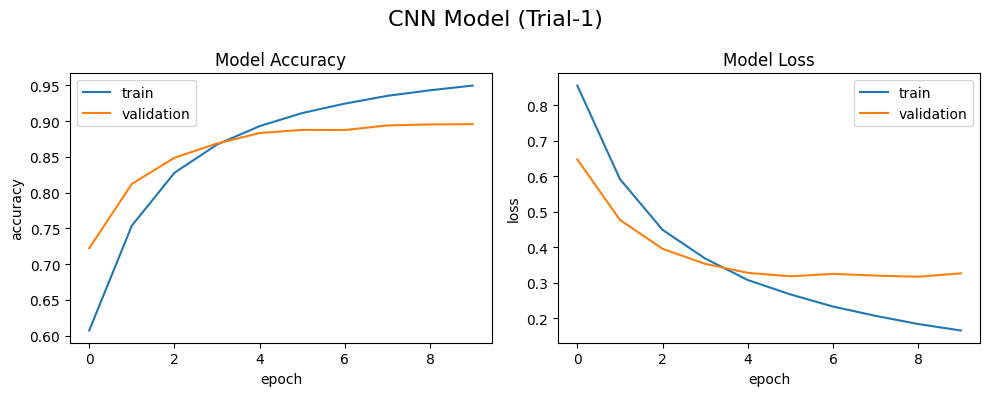

In [54]:
plotting_model_measurements(cnn_model_trial1_history,'CNN',1)

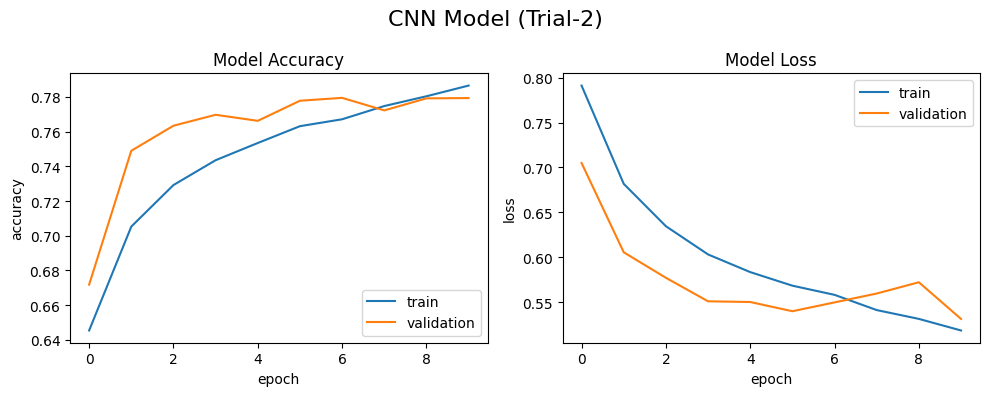

In [55]:
plotting_model_measurements(cnn_model_trial2_history,'CNN',2)

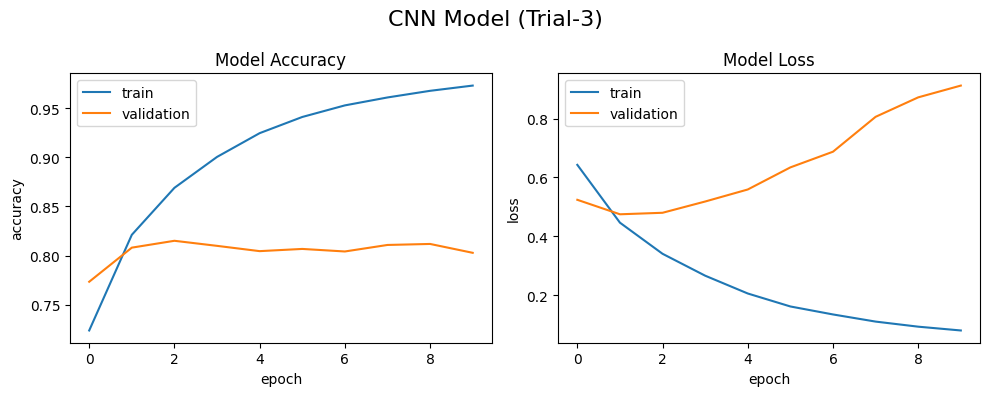

In [56]:
plotting_model_measurements(cnn_model_trial3_history,'CNN',3)

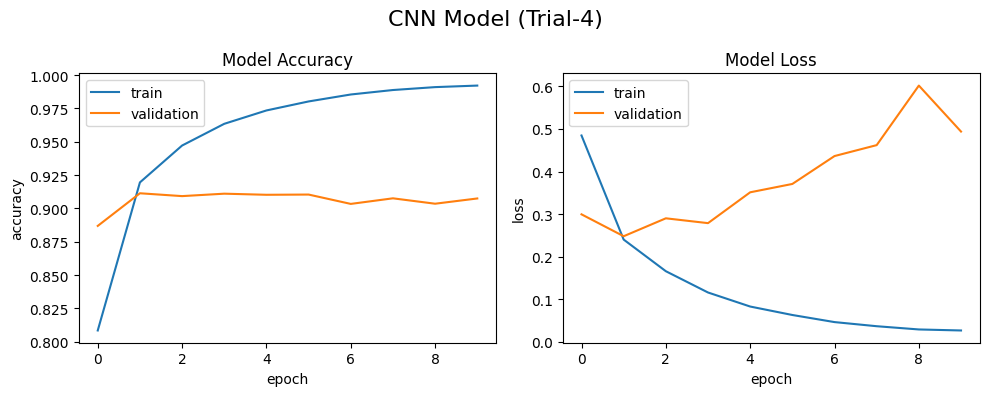

In [57]:
plotting_model_measurements(cnn_model_trial4_history,'CNN',4)

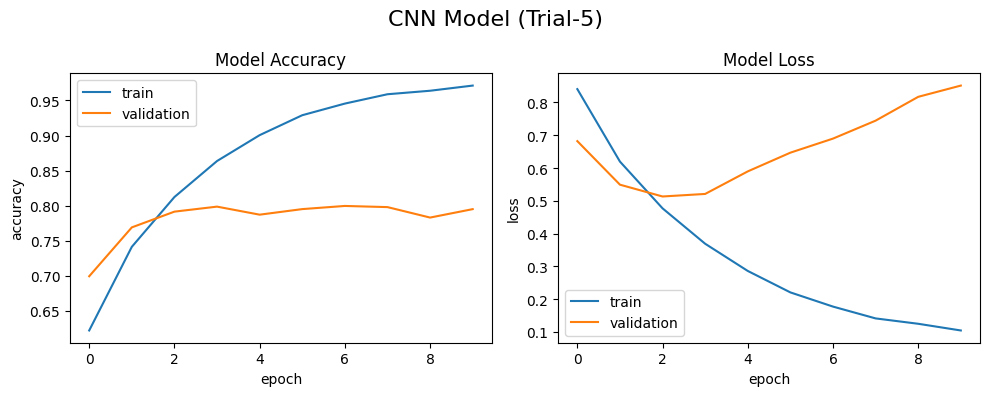

In [58]:
plotting_model_measurements(cnn_model_trial5_history,'CNN',5)

## **Plotting The Accuracies For all Trials**

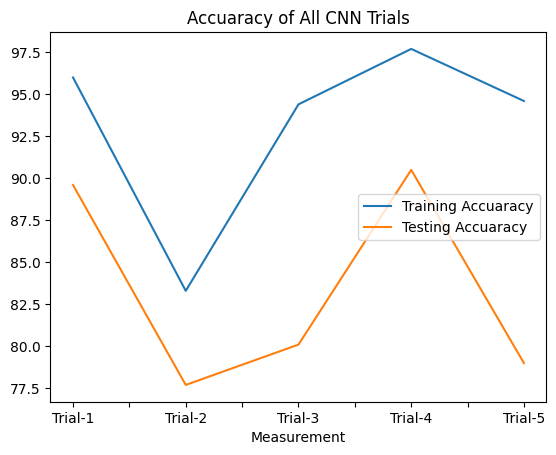

In [59]:
cnn_model_trials_df[['Measurement','Training Accuaracy','Testing Accuaracy']].plot(x='Measurement', title = 'Accuaracy of All CNN Trials');
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/CNN Model (All Trials Accuracies).png')

## **Saving The Models**

In [ ]:
cnn_model_trial1.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/CNN/CNN_model_trial1_Saved')
cnn_model_trial2.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/CNN/CNN_model_trial2_Saved')
cnn_model_trial3.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/CNN/CNN_model_trial3_Saved')
cnn_model_trial4.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/CNN/CNN_model_trial4_Saved')
cnn_model_trial5.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/CNN/CNN_model_trial5_Saved')
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial5_Saved')

# **Long Short Term Memory (LSTM) Architecture**

## **Building The Model**


In [ ]:

def build_LSTM(Conv1D,Dense1,Dense2,lstm_units,_learning_rate,embedding_trainable,optimizer_type,model_name):
    model = models.Sequential(name=model_name)
    model.add(layers.Embedding(num_of_words, num_of_dimensions, input_length=max_num_of_words,name='embedding_Layer'))
    if Conv1D:
      model.add(layers.Conv1D(64, 8, activation = 'relu'))
    
    model.add(layers.Bidirectional(layers.LSTM(lstm_units, dropout = 0.2, recurrent_dropout = 0.2)))
    
    if Dense1:
      model.add(layers.Dense(256, activation='relu'))
      model.add(layers.Dropout(0.5))
    
    if Dense2:
      model.add(layers.Dense(64, activation='relu'))
      model.add(layers.Dropout(0.5))
    
    model.add(layers.Dense(3, activation='softmax',name='Output_Layer'))
    model.layers[0].set_weights([embedding_matrix])
    if embedding_trainable:
       model.layers[0].trainable = True
    else:
       model.layers[0].trainable = False
    
    if optimizer_type=='adam':
      model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),metrics=['accuracy',f1_m,precision_m, recall_m])
    else:
      model.compile(loss='categorical_crossentropy',optimizer = tf.keras.optimizers.RMSprop(learning_rate=_learning_rate),metrics=['accuracy',f1_m,precision_m, recall_m])
    
    model.summary()
    return model


lstm_model_trials_dict = {
             'Measurement' : ['Trial-1', 'Trial-2' , 'Trial-3', 'Trial-4', 'Trial-5'], # Trial-1 => 0 , Trial-2 => 1 , ...
             'Training Accuaracy' : [0,0,0,0,0],
             'Testing Accuaracy' : [0,0,0,0,0],
             'Loss' : [0,0,0,0,0],
             'Embedding layer Trainable':['No','No','No','No','No']
}



## **LSTM Model Training Trials**


In [ ]:
# Trial-1 (embedding_trainable=True)

lstm_model_trial1 = build_LSTM(Conv1D=False , Dense1=False , Dense2=True , lstm_units=64 , _learning_rate=0.01 , embedding_trainable=True , optimizer_type='adam' , model_name='LSTM_Trial-1')
lstm_model_trial1_history = lstm_model_trial1.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-1'''
tf.keras.utils.plot_model(lstm_model_trial1, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 1).png")

lstm_model_trials_dict['Embedding layer Trainable'][0]='Yes'



# Trial-2 (embedding_trainable=False)

lstm_model_trial2 = build_LSTM(Conv1D=True , Dense1=False , Dense2=False , lstm_units=512 , _learning_rate=0.001 , embedding_trainable=False , optimizer_type='adam' , model_name='LSTM_Trial-2')
lstm_model_trial2_history = lstm_model_trial2.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-2'''
tf.keras.utils.plot_model(lstm_model_trial2, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 2).png")

lstm_model_trials_dict['Embedding layer Trainable'][1]='No'



# Trial-3 (embedding_trainable=False)

lstm_model_trial3 = build_LSTM(Conv1D=False , Dense1=True , Dense2=False , lstm_units=128 , _learning_rate=0.001 , embedding_trainable=False , optimizer_type='rmsp' , model_name='LSTM_Trial-3')
lstm_model_trial3_history = lstm_model_trial3.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-3'''
tf.keras.utils.plot_model(lstm_model_trial3, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 3).png")

lstm_model_trials_dict['Embedding layer Trainable'][2]='No'




# Trial-4 (embedding_trainable=True)

lstm_model_trial4 = build_LSTM(Conv1D=True , Dense1=True , Dense2=True , lstm_units=128 , _learning_rate=0.001 , embedding_trainable=True , optimizer_type='rmsp' , model_name='LSTM_Trial-4')
lstm_model_trial4_history = lstm_model_trial4.fit(X_train, y_train,epochs=6,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-4'''
tf.keras.utils.plot_model(lstm_model_trial4, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 4).png")

lstm_model_trials_dict['Embedding layer Trainable'][3]='Yes'




# Trial-5 (embedding_trainable=True)

lstm_model_trial5 = build_LSTM(Conv1D=True , Dense1=True , Dense2=False , lstm_units=256 , _learning_rate=0.001 , embedding_trainable=True , optimizer_type='adam' , model_name='LSTM_Trial-5')
lstm_model_trial5_history = lstm_model_trial5.fit(X_train, y_train,epochs=6, verbose=1,batch_size=256,validation_split=0.2)

'''Plotting Model Architecture For Trial-5'''
tf.keras.utils.plot_model(lstm_model_trial5, show_shapes=True,to_file="/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (Trial 5).png")

lstm_model_trials_dict['Embedding layer Trainable'][4]='Yes'



## **Testing The Model Trials**

In [ ]:

# Trial-1
training_score = lstm_model_trial1.evaluate(X_train, y_train)
testing_score = lstm_model_trial1.evaluate(X_test, y_test)

print(f'\nTrial 1')
print(f'Training Accuaracy (Trial 1): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 1): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 1 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][0]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][0]=round(testing_score[1]*100,1)



# Trial-2
training_score = lstm_model_trial2.evaluate(X_train, y_train)
testing_score = lstm_model_trial2.evaluate(X_test, y_test)

print(f'\nTrial 2')
print(f'Training Accuaracy (Trial 2): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 2): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 2 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][1]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][1]=round(testing_score[1]*100,1)




# Trial-3
training_score = lstm_model_trial3.evaluate(X_train, y_train)
testing_score = lstm_model_trial3.evaluate(X_test, y_test)

print(f'\nTrial 3')
print(f'Training Accuaracy (Trial 3): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 3): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 3 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][2]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][2]=round(testing_score[1]*100,1)




# Trial-4
training_score = lstm_model_trial4.evaluate(X_train, y_train)
testing_score = lstm_model_trial4.evaluate(X_test, y_test)

print(f'\nTrial 4')
print(f'Training Accuaracy (Trial 4): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 4): {round(testing_score[1]*100,1)}%')

'''   Save the data of trial 4 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][3]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][3]=round(testing_score[1]*100,1)




# Trial-5
training_score = lstm_model_trial5.evaluate(X_train, y_train)
testing_score = lstm_model_trial5.evaluate(X_test, y_test)

print(f'\nTrial 5')
print(f'Training Accuaracy (Trial 5): {round(training_score[1]*100,1)}%')
print(f'Testing Accuaracy (Trial 5): {round(testing_score[1]*100,1)}%\n\n')

'''   Save the data of trial 5 in lstm model trials dictionary   '''
lstm_model_trials_dict['Training Accuaracy'][4]=round(training_score[1]*100,1)
lstm_model_trials_dict['Testing Accuaracy'][4]=round(testing_score[1]*100,1)




1371/1371 [==============================] - 45s 33ms/step - loss: 0.3327 - accuracy: 0.9067 - f1_m: 0.9062 - precision_m: 0.9088 - recall_m: 0.9038

Trial 1
Training Accuaracy (Trial 1): 95.6%
Testing Accuaracy (Trial 1): 90.7%
1371/1371 [==============================] - 43s 32ms/step - loss: 0.4360 - accuracy: 0.8413 - f1_m: 0.8405 - precision_m: 0.8491 - recall_m: 0.8323

Trial 2
Training Accuaracy (Trial 2): 91.2%
Testing Accuaracy (Trial 2): 84.1%
1371/1371 [==============================] - 45s 33ms/step - loss: 0.3795 - accuracy: 0.8583 - f1_m: 0.8568 - precision_m: 0.8726 - recall_m: 0.8420

Trial 3
Training Accuaracy (Trial 3): 87.5%
Testing Accuaracy (Trial 3): 85.8%
1371/1371 [==============================] - 39s 29ms/step - loss: 0.3651 - accuracy: 0.8965 - f1_m: 0.8965 - precision_m: 0.8992 - recall_m: 0.8940

Trial 4
Training Accuaracy (Trial 4): 93.7%
Testing Accuaracy (Trial 4): 89.6%
1371/1371 [==============================] - 39s 29ms/step - loss: 0.3362 - accuracy

In [46]:
lstm_model_trials_df = pd.DataFrame(lstm_model_trials_dict)
lstm_model_trials_df.to_csv('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Files/LSTM_Trials_Table.csv')
lstm_model_trials_df

,Measurement,Training Accuaracy,Testing Accuaracy,Loss,Embedding layer Trainable
0,Trial-1,95.6,90.7,0,Yes
1,Trial-2,91.2,84.1,0,No
2,Trial-3,87.5,85.8,0,No
3,Trial-4,93.7,89.6,0,Yes
4,Trial-5,96.8,91.1,0,Yes


## **Plotting The Accuracy and Loss For each Trial**

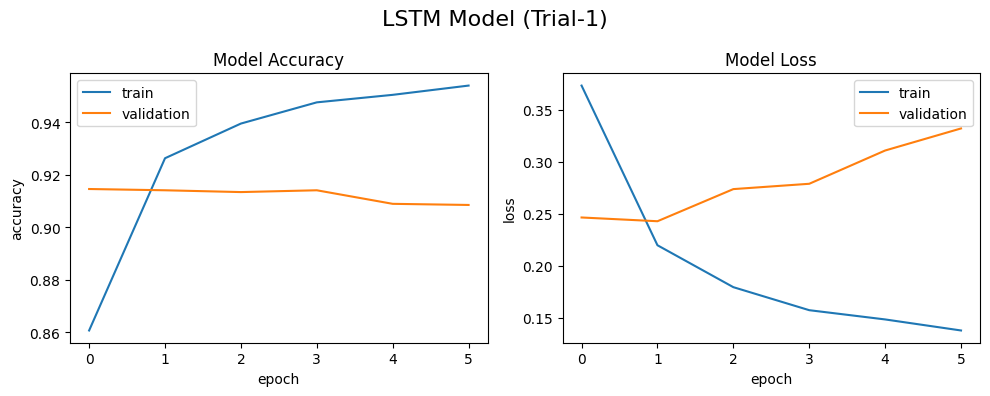

In [38]:
plotting_model_measurements(lstm_model_trial1_history,'LSTM',1)

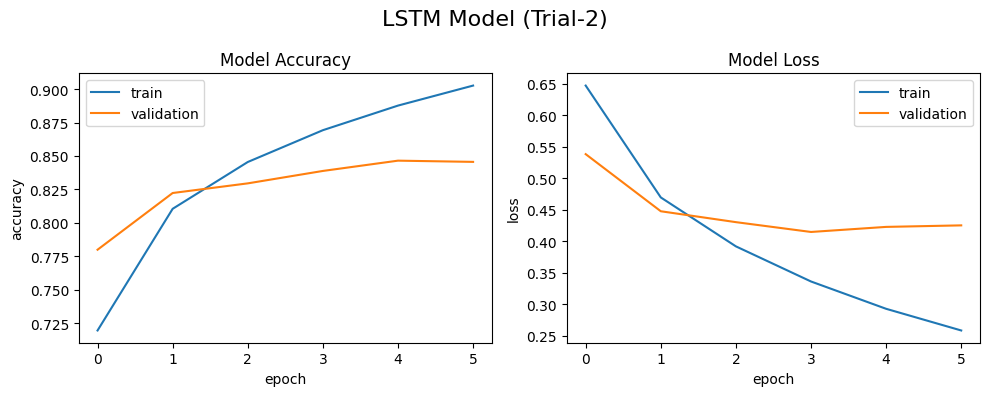

In [ ]:
plotting_model_measurements(lstm_model_trial2_history,'LSTM',2)

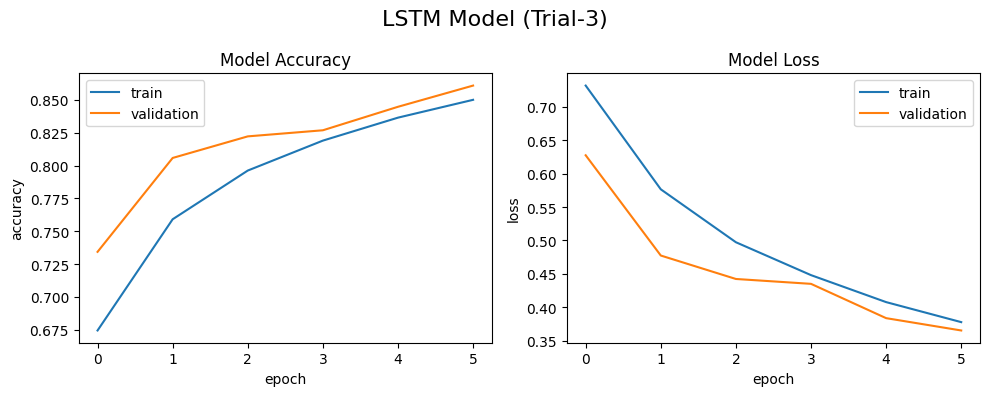

In [ ]:
plotting_model_measurements(lstm_model_trial3_history,'LSTM',3)

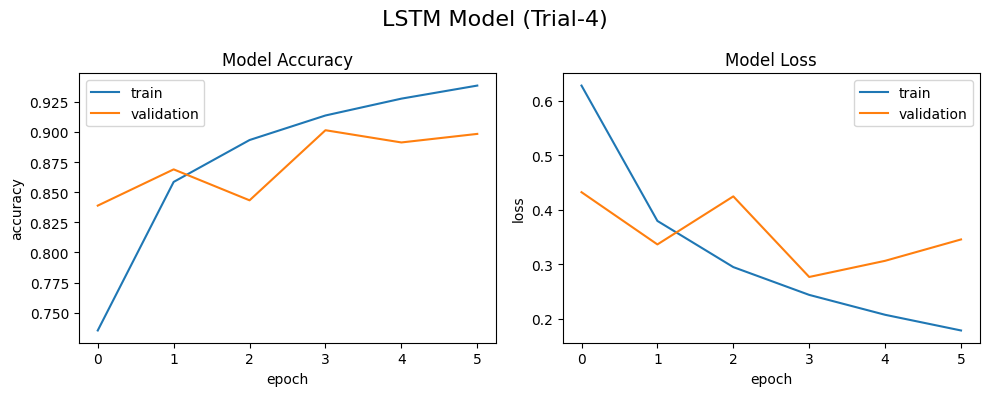

In [ ]:
plotting_model_measurements(lstm_model_trial4_history,'LSTM',4)

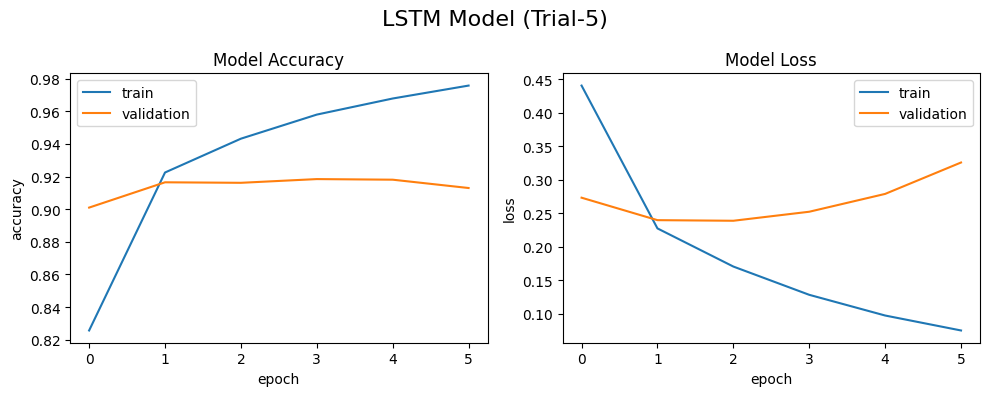

In [ ]:
plotting_model_measurements(lstm_model_trial5_history,'LSTM',5)

## **Plotting The Accuracies For all Trials**

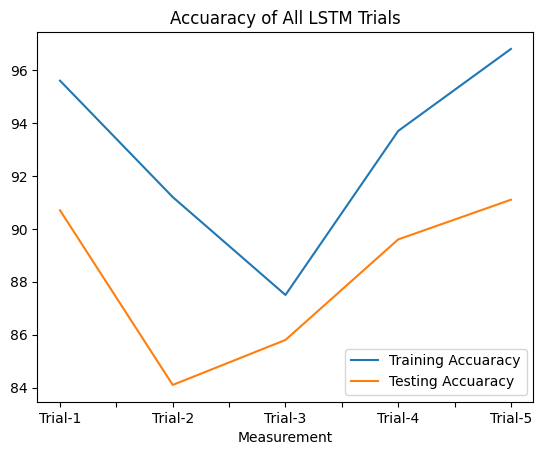

In [39]:
lstm_model_trials_df[['Measurement','Training Accuaracy','Testing Accuaracy']].plot(x='Measurement', title = 'Accuaracy of All LSTM Trials');
plt.savefig('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Images/LSTM Model (All Trials Accuracies).png')

## **Saving The Models**

In [ ]:
lstm_model_trial1.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial1_Saved')
lstm_model_trial2.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial2_Saved')
lstm_model_trial3.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial3_Saved')
lstm_model_trial4.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial4_Saved')
lstm_model_trial5.save('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial5_Saved')
# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial5_Saved')



  

---


#  > **We Notice that the high accuracy for the 2 models after training them is:-**


  *   ### CNN Model => **Trial 4**
  *   ### LSTM Model => **Trial 5**


---





# **New tweets Predictions**

## **Labels**

*   Negative => 0
*   Positive => 1
*   Neutral  => 2


---



In [191]:
def sentiment_category(label_id):
    label = ''
    if label_id==1:
        label = 'positive'
    elif label_id==2:
        label = 'neutral'
    else:
        label = 'negative'
    return label

## **Using CNN Model**

In [26]:
cnn_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/CNN/CNN_model_trial4_Saved',
                                              custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m })
cnn_model.summary()

Model: "CNN_Trial-4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding)  (None, 49, 300)          9600000   
                                                                 
 conv1d_10 (Conv1D)          (None, 49, 128)           614528    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 16, 128)          0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, 16, 128)           262272    
                                                                 
 max_pooling1d_7 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_12 (Conv1D)          (None, 5, 128)            

In [281]:
# Postive Example
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(new_tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {text}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = "Sooo SAD I will miss you here in San Diego"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(new_tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {text}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = " My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(new_tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = cnn_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {text}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')


1/1 [==============================] - 0s 43ms/step
Text: High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports
Label ID: 1
Label Name: positive
Polarity: 0.9909900426864624


1/1 [==============================] - 0s 41ms/step
Text: Sooo SAD I will miss you here in San Diego
Label ID: 0
Label Name: negative
Polarity: 0.9999892711639404


1/1 [==============================] - 0s 53ms/step
Text:  My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!
Label ID: 2
Label Name: neutral
Polarity: 0.8654656410217285




## **Using LSTM Model**

In [283]:
lstm_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/ChatGPT_SentimentAnalysis/Saved Models/LSTM/LSTM_model_trial5_Saved',
                                              custom_objects={"f1_m": f1_m, "precision_m": precision_m, "recall_m": recall_m })
lstm_model.summary()

Model: "LSTM_Trial-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_Layer (Embedding)  (None, 49, 300)          9600000   
                                                                 
 conv1d_3 (Conv1D)           (None, 42, 64)            153664    
                                                                 
 bidirectional_9 (Bidirectio  (None, 512)              657408    
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 Output_Layer (Dense)        (None, 3)                 771       
                                                      

In [284]:
# Postive Example
tweet = "High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports"  # positive

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(new_tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {text}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# Negative Example
tweet = "Sooo SAD I will miss you here in San Diego"  # negative

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(new_tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {text}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')



# neutral Example
tweet = " My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!"  # neutral

new_tweet=clean_text(tweet)
new_tweet=word_tokenize(new_tweet)
new_tweet=lemmatizer.lemmatize(new_tweet)
sequences = tokenizer.texts_to_sequences([new_tweet])
data = pad_sequences(sequences, maxlen=max_num_of_words)

output = lstm_model.predict(data)
label_id = np.argmax(output)
print(f'Text: {text}\nLabel ID: {label_id}\nLabel Name: {sentiment_category(label_id)}\nPolarity: {np.take(output, label_id)}\n\n')


1/1 [==============================] - 1s 985ms/step
Text: High quality pants. Very comfortable and great for sport activities. Good price for nice quality! I recommend to all fans of sports
Label ID: 1
Label Name: positive
Polarity: 0.997701108455658


1/1 [==============================] - 0s 53ms/step
Text: Sooo SAD I will miss you here in San Diego
Label ID: 0
Label Name: negative
Polarity: 0.9965170621871948


1/1 [==============================] - 0s 47ms/step
Text:  My daughter went to a Bday party today caled, 'Grace' of Cakes...the little girl is named Grace & they made cupcakes!
Label ID: 2
Label Name: neutral
Polarity: 0.9750921130180359


